In [3]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
from scipy.special import logsumexp
import pandas as pd
import numpy
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
# from nn_models import Feedforward
# from bayesian_regression import Bayesian_Regression
import sys
%matplotlib inline

Assume that the outcome $y$ can be modeled by the following process:
\begin{aligned}
y &= f(x) + \epsilon = w_1x + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)\\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}


$$\log \left[ \left(\prod_{n=1}^Np(y_n|x_n, \textbf{w})\right) p(\textbf{w}) \right] = -\frac{1}{2}\textbf{w}^T\left( \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \right)\textbf{w} + \textbf{w}^T \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right) + const.$$

Since we know this is a quadratic exponential and is Guassian, comparing with a standard multivariate Gaussian, the posterior is a bivariate Gaussian $\textbf{w} \sim \mathcal{N}(\mu_{post}, \Sigma_{post})$, where

$$\begin{aligned}
    \Sigma_{post} ^{-1} &= \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \\
    \mu_{post} &= \Sigma_{post} \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right)
\end{aligned}
$$

In this particular case, 

$$\Sigma_{post} ^{-1} = \begin{bmatrix}
    1 & 0 \\
    0 & 0.5
  \end{bmatrix}^{-1} + \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N \begin{bmatrix}
    1\\
    x_n
  \end{bmatrix} \begin{bmatrix}
    1 & x_n
  \end{bmatrix} = \begin{bmatrix}
    1+\frac{N}{\sigma_{\epsilon}^2} & \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n \\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n & 2+\frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n^2
  \end{bmatrix}$$
  
whereas the terms inside the brackets for $\mu_{post}$ are
  
$$\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} = 0 + \begin{bmatrix}
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N y_n\\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_ny_n
  \end{bmatrix}$$

In [4]:
#Read in the data
df = pd.read_csv('data/HW0_data.csv')
X = df['x'].values.reshape(-1,1)
y = df['y'].values.reshape(-1,1)
X_mat = sm.add_constant(X)

In [5]:
#Construct the derived posterior inverse covariance matrix from above
cov_postinv = np.zeros([2,2])
cov_postinv[0][0] = 1 + len(X)/0.5
cov_postinv[0][1] = X.sum()/0.5
cov_postinv[1][0] = X.sum()/0.5
cov_postinv[1][1] = 2 + (X**2).sum()/0.5
#Get the covariance by taking the inverse
cov_post = np.linalg.inv(cov_postinv)

#Construct the vector within the brackets for mu_post from above
vector = np.zeros([2,1])
vector[0] = y.sum()/0.5
vector[1] = (X*y).sum()/0.5
#Get the posterior mean
mu_post = np.matmul(cov_post, vector)

In [6]:
mu_post

array([[8.81958297],
       [5.21603948]])

In [7]:
def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train - forward(W, x_train))**2, axis=0)
        return constant + exponential

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
#     init_mean = nn.weights.flatten()
#     init_mean = np.ones(D)
    init_mean = np.array([8.81958297,5.2])
    init_log_std = -5 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

##polynomial function
def forward(w, x):
    return np.matmul(x, w.T)

In [8]:
D = 2
N = X_mat.shape[0]
sigma_e = 0.5
params = variational_inference(np.array([[1,0],[0,0.5]]),sigma_e, y, X_mat, forward, S=1000, \
                               max_iteration=1000, step_size=1e-1, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -30539.466056153142; gradient mag: 152.62214679327647
Iteration 100 lower bound -30536.363573139875; gradient mag: 4.263828645164401
Iteration 200 lower bound -30536.41529699454; gradient mag: 5.2189788551913905
Iteration 300 lower bound -30536.399523534914; gradient mag: 4.536858396887439
Iteration 400 lower bound -30536.400756914736; gradient mag: 12.99753436814084
Iteration 500 lower bound -30536.465640433682; gradient mag: 12.43011565086504
Iteration 600 lower bound -30536.41793852928; gradient mag: 25.94459523568
Iteration 700 lower bound -30536.39405035595; gradient mag: 10.57352972331591
Iteration 800 lower bound -30536.385576378372; gradient mag: 3.887746753029703
Iteration 900 lower bound -30536.468270997004; gradient mag: 1.1049825733521936


In [9]:
mu_VI = params[:D]
cov_VI = np.diag(np.exp(params[D:])**2)

In [10]:
mu_VI, mu_post

(array([8.84104446, 5.21864052]), array([[8.81958297],
        [5.21603948]]))

Text(0.5, 1.0, 'True posterior (in red) vs. VI posterior (in blue)')

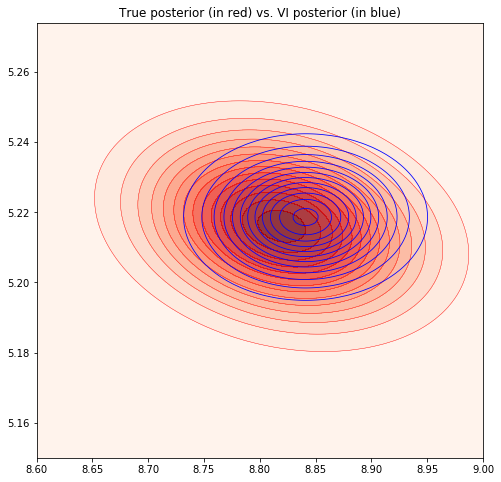

In [11]:
x, y = numpy.mgrid[8.6:9:.001, 5.15:5.275:.001]
pos = numpy.dstack((x, y))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

z = scipy.stats.multivariate_normal(mu_post.flatten(), cov_post).pdf(pos)
z_VI = scipy.stats.multivariate_normal(mu_VI, cov_VI).pdf(pos)

ax.contourf(x, y, z, levels=14, cmap='Reds', alpha=0.8)
ax.contour(x, y, z, levels=14, linewidths=0.4, colors='red')

ax.contour(x, y, z_VI, levels=14, linewidths=0.8, colors='blue')
plt.title('True posterior (in red) vs. VI posterior (in blue)')

In [12]:
ndim = 2
mu0 = np.zeros(ndim)
Sigma0 = np.eye(ndim)
N = 1000
# nbins = 300

samples = np.random.multivariate_normal(mu0, Sigma0, size=N)

In [13]:
def w1(z):
    return np.sin(2*np.pi*z[0]/4)

def w2(z):
    first = (z[0]-1)/0.6
    return 3*np.exp(-0.5*first**2)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def w3(z):
    first = (z[0]-1)/0.3
    return 3*sigmoid(first)

def p1(z):
    '''Apply posterior p_1 to bivariate z.'''
    first = (np.linalg.norm(z)-2)/0.4
    second = np.exp(-0.5*((z[0] - 2)/0.6)**2)
    third = np.exp(-0.5*((z[0] + 2)/0.6)**2)
    
    return np.exp(-0.5*first**2 + np.log(second+third))

def p2(z):
    '''Apply posterior p_2 to bivariate z.'''
    first = (z[1] - w1(z))/0.4
    return np.exp(-0.5*first**2)

def p3(z):
    '''Apply posterior p_3 to bivariate z.'''
    first = np.exp(-0.5*((z[1] - w1(z))/0.35)**2)
    second = np.exp(-0.5*((z[1] - w1(z) + w2(z))/0.35)**2)
    
    return first+second

def p4(z):
    '''Apply posterior p_4 to bivariate z.'''
    first = np.exp(-0.5*((z[1] - w1(z))/0.4)**2)
    second = np.exp(-0.5*((z[1] - w1(z) + w3(z))/0.35)**2)
    
    return first+second

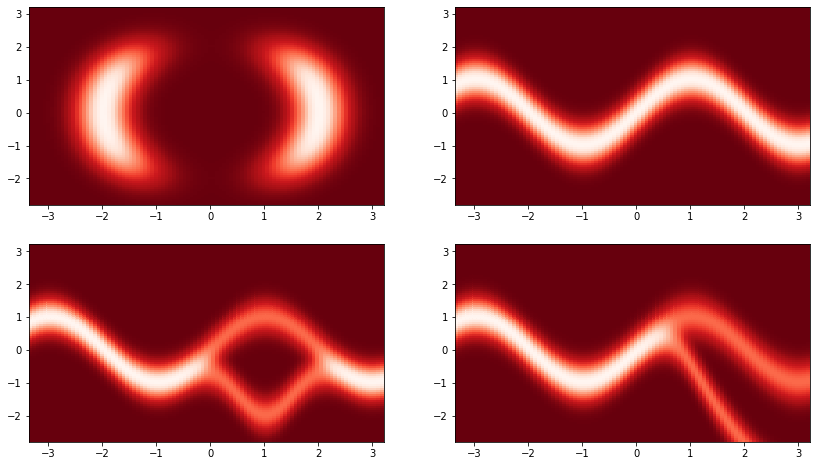

In [14]:
fig,ax=plt.subplots(2,2,figsize = (14,8))
nbins = 100
x, y = samples[:, 0], samples[:, 1]
# density = scipy.stats.kde.gaussian_kde([x, y])
xi, yi = numpy.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

zi = np.array([p1(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p2(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p3(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p4(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

In [86]:
def hprime(x, h='tanh'):
    if h=='tanh':
        return 1/np.cosh(x)**2
    
def logdet_jac(w, z, b):
    return hprime(np.dot(w,z) + b) * w

def logdet_jac_vec(w, z, b):
    inner = hprime(np.dot(w, z) + b)
    reshaped = np.repeat(inner.reshape(1, -1), len(w), axis=0)
    diagonal = np.diag(w)
    return np.dot(diagonal, reshaped).T

def free_energy(logp, samples, logq0, W, U, b):
    '''
    logp: log p(x, z_K) likelihood function parameterised by theta.
    samples: a (K+1) x dim_z x num_samples array such that each row is samples after kth flow,
    for k={0,1,...,K}.
    logq0: log PDF of initial samples.
    W: a K x dim_z matrix, with flow parameter w_k per row.
    U: a K x dim_z matrix, with flow parameter u_k per row.
    b: a K dimensional vector, with flow parameter b_k.''' 
    
    first = np.mean(logq0(samples[0, :, :]))
    
    second = np.mean(logp(samples[-1, :, :]))
    
    middle = 0
    for k in range(W.shape[0]):
        middle += np.log(1 + np.dot(U[k], logdet(W[k], samples[k-1, :, :], b[k])))
        
    third = np.mean(middle)
    
    return first - second - third

In [88]:
dim_z = 2
K = 3
num_samples = 4

W = np.random.randn(K,dim_z)
U = np.random.randn(K,dim_z)
b = np.random.randn(K)

Z = np.random.randn(K+1, dim_z, num_samples)
k=0

logdet_jac_vec(W[k], Z[k-1, :, :], b[k])

array([[ 1.07660716, -0.70294338],
       [ 0.78525138, -0.51271   ],
       [ 0.47296   , -0.30880725],
       [ 1.00012255, -0.65300469]])